# 使用块的网络（VGG）
:label:`sec_vgg`

虽然 AlexNet 证明深层神经网络卓有成效，但它没有提供一个通用的模板来指导后续的研究人员设计新的网络。
在下面的几个章节中，我们将介绍一些常用于设计深层神经网络的启发式概念。

与芯片设计中工程师从放置晶体管到逻辑元件再到逻辑块的过程类似，神经网络结构的设计也逐渐变得更加抽象。研究人员开始从单个神经元的角度思考问题，发展到整个层次，现在又转向模块，重复各层的模式。

使用块的想法首先出现在牛津大学的 [视觉几何组（visualgeometry Group）](http://www.robots.ox.ac.uk/~vgg/) (VGG)的 *VGG网络* 中。通过使用循环和子程序，可以很容易地在任何现代深度学习框架的代码中实现这些重复的结构。

## (**VGG块**)

经典卷积神经网络的基本组成部分是下面的这个序列：
1. 带填充以保持分辨率的卷积层；
1. 非线性激活函数，如ReLU；
1. 汇聚层，如最大汇聚层。

而一个 VGG 块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。在最初的 VGG 论文 :cite:`Simonyan.Zisserman.2014` 中，作者使用了带有 $3\times3$ 卷积核、填充为 1（保持高度和宽度）的卷积层，和带有 $2 \times 2$ 池化窗口、步幅为 2（每个块后的分辨率减半）的最大汇聚层。在下面的代码中，我们定义了一个名为 `vgg_block` 的函数来实现一个 VGG 块。


该函数有三个参数，分别对应于卷积层的数量 `num_convs`、输入通道的数量 `in_channels`
和输出通道的数量  `out_channels`.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## [**VGG网络**]

与 AlexNet、LeNet 一样，VGG 网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。如 :numref:`fig_vgg` 中所示。

![从AlexNet到VGG，它们本质上都是块设计。](../img/vgg.svg)
:width:`400px`
:label:`fig_vgg`


VGG神经网络连续连接 :numref:`fig_vgg` 的几个 VGG 块（在 `vgg_block` 函数中定义）。其中有超参数变量 `conv_arch` 。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则与AlexNet中的相同。

原始 VGG 网络有 5 个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。
第一个模块有 64 个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到 512。由于该网络使用 8 个卷积层和 3 个全连接层，因此它通常被称为 VGG-11。


In [2]:
conv_arch = ((1, 8), (1, 16), (2, 32), (2, 64), (2, 64))

下面的代码实现了 VGG-11。可以通过在 `conv_arch` 上执行 for 循环来简单实现。


In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 448), nn.ReLU(), 
        nn.Linear(448, 64), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(64, 10))

net = vgg(conv_arch)

接下来，我们将构建一个高度和宽度为 224 的单通道数据样本，以[**观察每个层输出的形状**]。


In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)
print(net)

Sequential output shape:	 torch.Size([1, 8, 112, 112])
Sequential output shape:	 torch.Size([1, 16, 56, 56])
Sequential output shape:	 torch.Size([1, 32, 28, 28])
Sequential output shape:	 torch.Size([1, 64, 14, 14])
Sequential output shape:	 torch.Size([1, 64, 7, 7])
Flatten output shape:	 torch.Size([1, 3136])
Linear output shape:	 torch.Size([1, 448])
ReLU output shape:	 torch.Size([1, 448])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Dropout output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Co

正如你所看到的，我们在每个块的高度和宽度减半，最终高度和宽度都为7。最后再展平表示，送入全连接层处理。

## 训练模型


除了使用略高的学习率外，[**模型训练**]过程与 :numref:`sec_alexnet` 中的 AlexNet 类似。


loss 0.127, train acc 0.952, test acc 0.909
2157.0 examples/sec on cuda:0


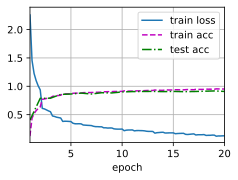

In [5]:
lr, num_epochs, batch_size = 0.1, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
torch.set_printoptions(sci_mode=False, threshold=2000000, precision=0, edgeitems=None, linewidth=None)
f = open('./vgg.txt', 'w', encoding='utf-8')
print(net)
f.write(str(net))
f.write('\n')
for layer in net:
    #print(layer)
    f.write(str(layer))
    f.write('\n')
    if layer.__class__.__name__ in ("Linear") :
        #print(layer.weight.data * 1024  ,'\n', layer.bias * 1024)
        f.write(str(layer.weight.data * 1024))
        f.write('\n')
        f.write(str(layer.bias * 1024))
        f.write('\n')
    elif layer.__class__.__name__ in ("Sequential") :
        for hidden_layer in layer:
            #print(hidden_layer)
            if hidden_layer.__class__.__name__ in ("Conv2d") :
                f.write(str(hidden_layer.weight.data * 1024))
                f.write('\n')
                f.write(str(hidden_layer.bias * 1024))
                f.write('\n')
f.close()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential

## 小结

* VGG-11 使用可复用的卷积块构造网络。不同的 VGG 模型可通过每个块中卷积层数量和输出通道数量的差异来定义。
* 块的使用导致网络定义的非常简洁。使用块可以有效地设计复杂的网络。
* 在VGG论文中，Simonyan和Ziserman尝试了各种架构。特别是他们发现深层且窄的卷积（即$3 \times 3$）比较浅层且宽的卷积更有效。

## 练习

1. 打印层的尺寸时，我们只看到 8 个结果，而不是 11 个结果。剩余的 3 层信息去哪了？
1. 与 AlexNet 相比，VGG 的计算要慢得多，而且它还需要更多的显存。分析出现这种情况的原因。
1. 尝试将Fashion-MNIST数据集图像的高度和宽度从 224 改为 96。这对实验有什么影响？
1. 请参考 VGG 论文 :cite:`Simonyan.Zisserman.2014` 中的表1构建其他常见模型，如 VGG-16 或 VGG-19。


[Discussions](https://discuss.d2l.ai/t/1866)
